<a href="https://colab.research.google.com/github/niranjan-sa/DataScience/blob/master/Innoplexus_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.listdir('drive/')
train = pd.read_csv('drive/My Drive/Data Science Preparation/Innoplexus Sentiment Analysis/train_F3WbcTw.csv')
test = pd.read_csv('drive/My Drive/Data Science Preparation/Innoplexus Sentiment Analysis/test_tOlRoBf.csv')

Checking the names of drugs in the train and the test set. We observe that 86 drugs are common in the train and test set. Later we will go for one hot encoding of these drugs.

In [15]:
a = set(train.drug.to_list())
b = set(test.drug.to_list())
print (len(a))
print (len(b))
print (len(a.intersection(b)))
print (a.difference(b))

print (train.shape)
print (test.shape)

102
95
86
{'amjevita', 'alunbrig', 'crizotnib', 'filgotinib', 'rhumab 2h7', 'infliximab-dyyb', 'pemetrexed disodium', 'guselkumab', 'pemrolizumab', 'alectnib', 'geftinib', 'cyramza', 'nivolumabb', 'ct-p13', 'giotrif', 'ketruda'}
(5279, 4)
(2924, 3)


In [9]:
train.head(3)

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why you’d want to ...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2


In [10]:
train.drug.unique().shape

(102,)

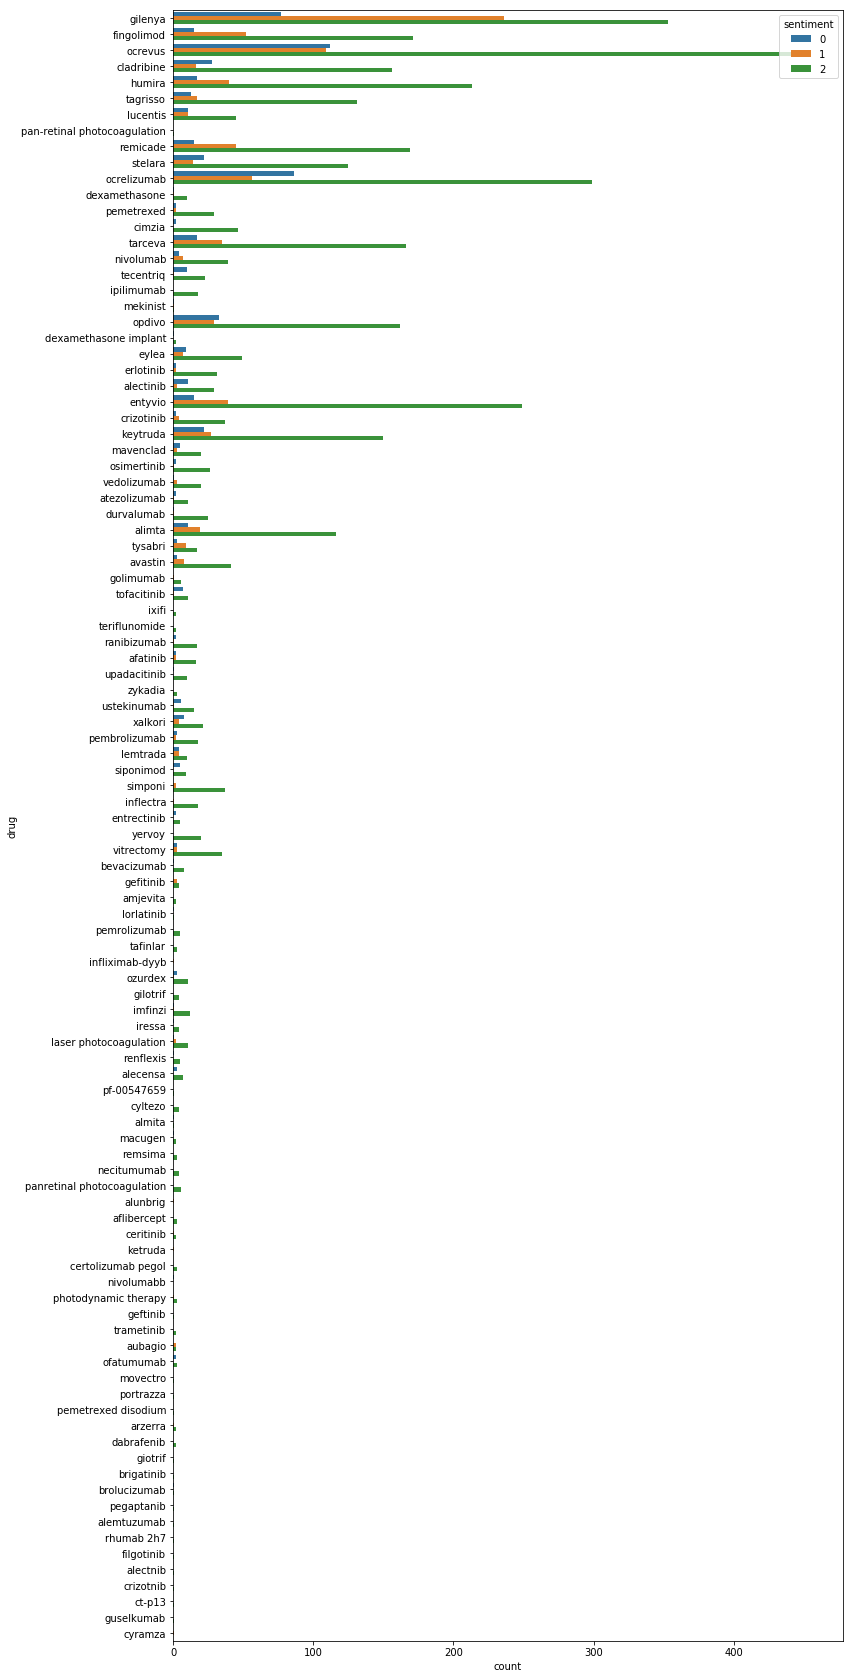

In [38]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 12,30
sns.countplot(y='drug', hue='sentiment', data=train)

From the above plot we see that some drugs have a lot of reviews while some have very less. Therefore, in the below graph we try to find of individual distribution of reviews within 3 sentiments for each drug. The following graph depticts the same.

In [0]:
tmp = (train.groupby('drug'))['sentiment'].value_counts(normalize=True).rename('percentage').mul(100).reset_index()

In [45]:
tmp.head()

,drug,sentiment,percentage
0,afatinib,2,80.0
1,afatinib,0,10.0
2,afatinib,1,10.0
3,aflibercept,2,100.0
4,alecensa,2,70.0


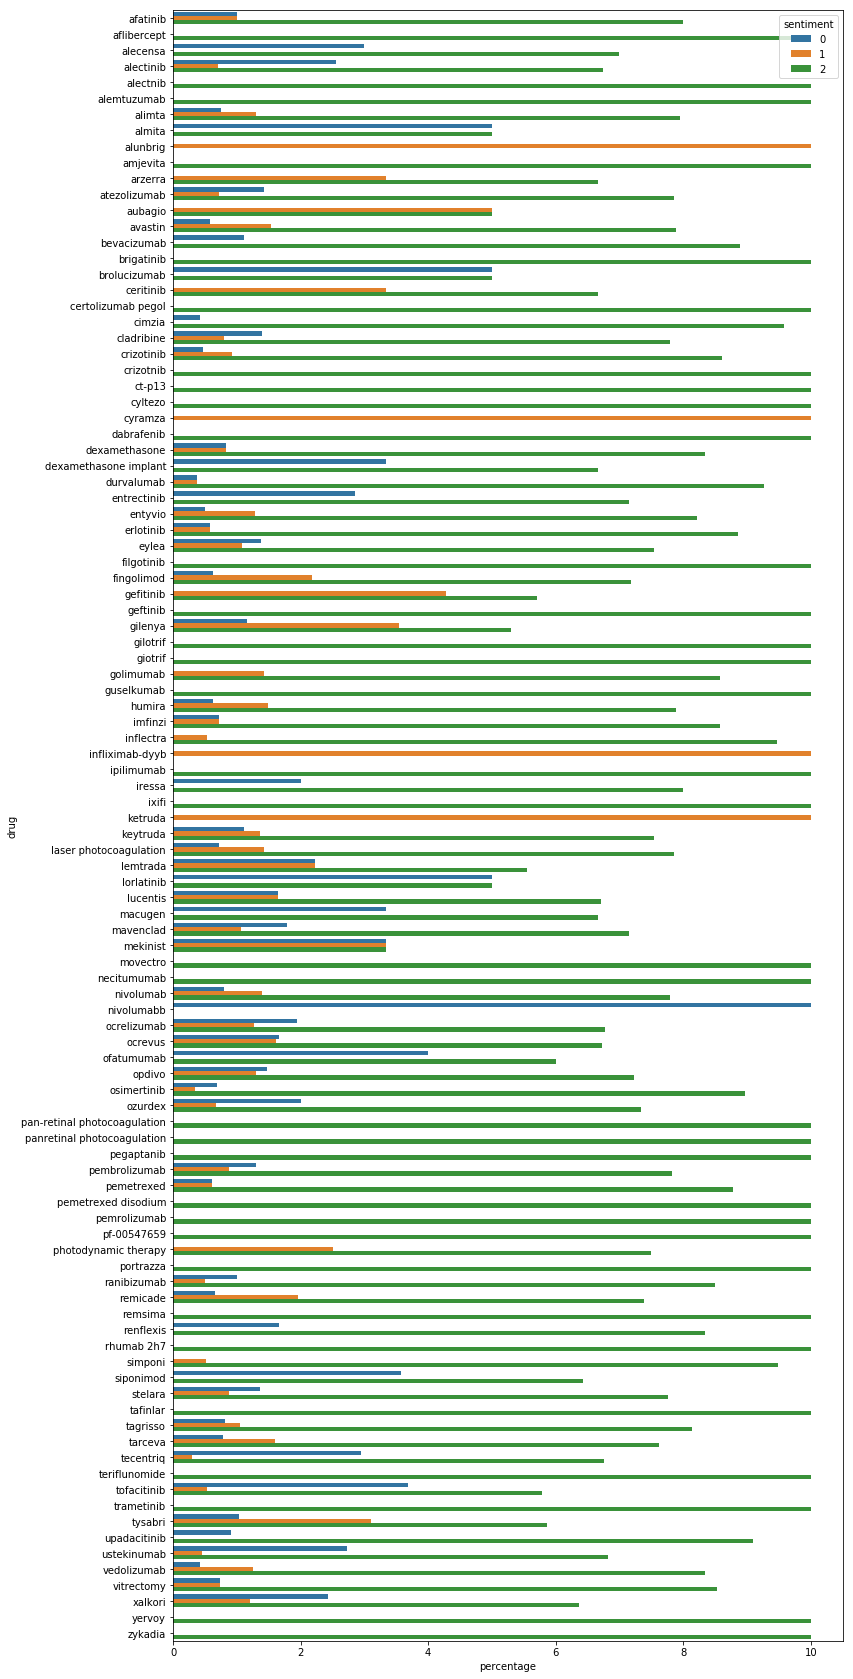

In [50]:
p = sns.barplot(x="percentage", y="drug", hue="sentiment", data=tmp)

Individual distributions seem to be highly skewed. Some drugs have only positive sentiments, while some have only negative. Very few drugs have a good mix of both positive and negative reviews.

In [52]:
test.drug.unique().shape

(95,)

Combining the train and the test set for combined preprocessing of the data.

In [53]:
combi = train.append(test, ignore_index=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


*One hot encoding of the drug names. (converting them to boolean to reduce memory consumption)*

In [0]:
dummies = pd.get_dummies(combi['drug']).astype('bool')

In [55]:
combi = pd.concat([combi, dummies], axis=1)
print (combi.shape)

(8203, 115)


In [56]:
combi.head()

,drug,sentiment,text,unique_hash,afainib,afatinib,aflibercept,alecensa,alectinib,alectnib,alemtuzumab,alimta,alitma,almita,alunbrig,amjevita,arzerra,atezolizumab,aubagio,avastin,bevacizumab,brigatinib,brolucizumab,ceritinib,certolizumab pegol,cimzia,cladribine,crizotinib,crizotnib,ct-p13,cyltezo,cyramza,dabrafenib,dexamethasone,dexamethasone implant,durvalumab,duvalumab,elotinib,entrectinib,entyvio,...,ofatumumab,opdivo,osimertinib,osmertinib,ozurdex,pan-retinal photocoagulation,panretinal photocoagulation,pegaptanib,pembrolizumab,pemetrexed,pemetrexed disodium,pemrolizumab,pf-00547659,photodynamic therapy,portrazza,ranibizumab,remicade,remsima,renflexis,rhumab 2h7,risankizumab,simponi,siponimod,stelara,stellara,tafinlar,tagrisso,tarceva,tecentriq,teriflunomide,tofacitinib,trametinib,tysabri,upadacitinib,ustekinumab,vedolizumab,vitrectomy,xalkori,yervoy,zykadia
0,gilenya,2.0,Autoimmune diseases tend to come in clusters. ...,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,gilenya,2.0,I can completely understand why you’d want to ...,9eba8f80e7e20f3a2f48685530748fbfa95943e4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,fingolimod,2.0,Interesting that it only targets S1P-1/5 recep...,fe809672251f6bd0d986e00380f48d047c7e7b76,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,ocrevus,2.0,"Very interesting, grand merci. Now I wonder wh...",bd22104dfa9ec80db4099523e03fae7a52735eb6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,gilenya,1.0,"Hi everybody, My latest MRI results for Brain ...",b227688381f9b25e5b65109dd00f7f895e838249,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [57]:
combi.tail()

,drug,sentiment,text,unique_hash,afainib,afatinib,aflibercept,alecensa,alectinib,alectnib,alemtuzumab,alimta,alitma,almita,alunbrig,amjevita,arzerra,atezolizumab,aubagio,avastin,bevacizumab,brigatinib,brolucizumab,ceritinib,certolizumab pegol,cimzia,cladribine,crizotinib,crizotnib,ct-p13,cyltezo,cyramza,dabrafenib,dexamethasone,dexamethasone implant,durvalumab,duvalumab,elotinib,entrectinib,entyvio,...,ofatumumab,opdivo,osimertinib,osmertinib,ozurdex,pan-retinal photocoagulation,panretinal photocoagulation,pegaptanib,pembrolizumab,pemetrexed,pemetrexed disodium,pemrolizumab,pf-00547659,photodynamic therapy,portrazza,ranibizumab,remicade,remsima,renflexis,rhumab 2h7,risankizumab,simponi,siponimod,stelara,stellara,tafinlar,tagrisso,tarceva,tecentriq,teriflunomide,tofacitinib,trametinib,tysabri,upadacitinib,ustekinumab,vedolizumab,vitrectomy,xalkori,yervoy,zykadia
8198,remicade,NaN,Reply posted for Hippopostrous. We are sorry t...,ac6e60bec9162ae66effd29a0dc9ad11ff966df6,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8199,gilenya,NaN,Aw Lorraine That's crap. What a shame you've h...,12afabb6210825308ead9894916abdfc912d7c43,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8200,opdivo,NaN,jskozio14\n That sounds like nonsense to me. ...,021bb88c92a71229288304d691d53c3ff7004e4b,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8201,stelara,NaN,It sounds like you're doing very well FG! I wo...,9936efcb83eded79fe9454df188edd7b96c6109e,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
8202,cladribine,NaN,"Hi @rambles too! It’s such a hard decision, is...",05402df12d6769d7f38ab40e0b81464e65e1df0a,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


**Text Conversions**

1.   Converting the reviews into lowercase
2.   Remove special characters, numbers, punctuations
3.   Remove small words with length <= 3



In [0]:
combi['text'] = combi['text'].str.lower()

In [0]:
combi['tidy_text'] = combi['text'].str.replace("[^a-zA-Z#]", " ")

In [0]:
combi['tidy_text'] = combi['tidy_text'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>3]))

**Tokenization of cleaned text**

In [63]:
tokenized_text = combi['tidy_text'].apply(lambda x: x.split())
print (tokenized_text.head())

0    [autoimmune, diseases, tend, come, clusters, g...
1    [completely, understand, want, results, report...
2    [interesting, that, only, targets, receptors, ...
3    [very, interesting, grand, merci, wonder, wher...
4    [everybody, latest, results, brain, cervical, ...
Name: tidy_text, dtype: object


In [73]:
print (len(tokenized_text))

8203


*removing stopwords*

In [65]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [74]:
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
stop_words = set(stopwords.words('english'))


def stopwords_removed(row):
  return [word for word in row if word not in stop_words]

tokenized_text = tokenized_text.apply(stopwords_removed)
print (len(tokenized_text))

8203


In [75]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_text = tokenized_text.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_text.head()

0    [autoimmun, disea, tend, come, cluster, gileny...
1    [complet, understand, want, result, report, le...
2    [interest, onli, target, receptor, rather, lik...
3    [veri, interest, grand, merci, wonder, lemtrad...
4    [everybodi, latest, result, brain, cervic, cor...
Name: tidy_text, dtype: object

Gluing the processed tokens together into our main data frame.

In [0]:
for i in range(len(tokenized_text)):
    tokenized_text[i] = ' '.join(tokenized_text[i])

combi['tidy_text'] = tokenized_text

# Visualizations and Analysis

In [0]:
train = combi.iloc[:5279,:]
test = combi.iloc[5279:, :]

In [78]:
del combi
import gc
gc.collect()

354

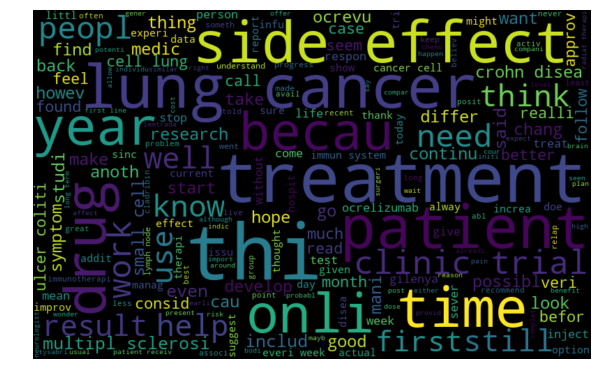

In [79]:
all_words = ' '.join([txt for txt in train['tidy_text']])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Word Cloud for all the text corpus**




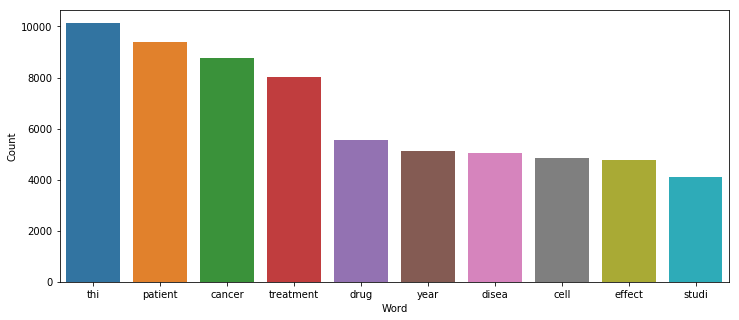

In [89]:
all_words = ' '.join([txt for txt in train['tidy_text']])
all_words = all_words.split()

a = nltk.FreqDist(all_words)
d = pd.DataFrame({'Word': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(12,5))
ax = sns.barplot(data=d, x= "Word", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

* Frequency distribution for whole text corpus

Word clouds for different Sentiments

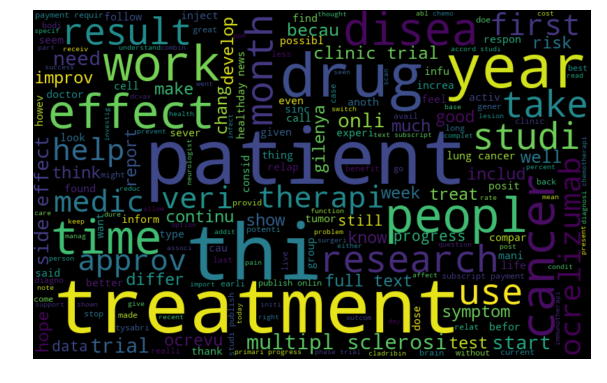

In [80]:
all_words = ' '.join([txt for txt in train['tidy_text'][train['sentiment']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

Word cloud for Sentiment Class 0

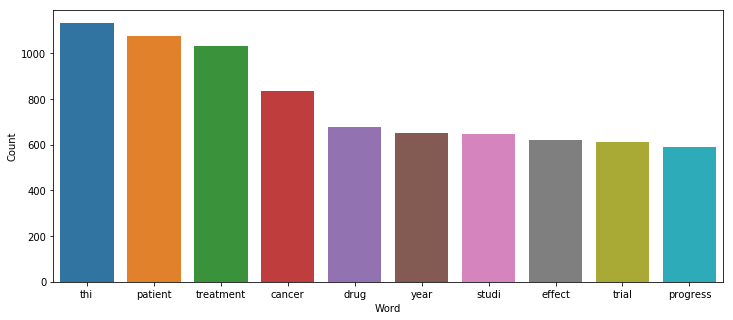

In [85]:
all_words = ' '.join([txt for txt in train['tidy_text'][train['sentiment']==0]])
all_words = all_words.split()

a = nltk.FreqDist(all_words)
d = pd.DataFrame({'Word': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(12,5))
ax = sns.barplot(data=d, x= "Word", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

* Frequency distribution (Sentiment Class 0)*

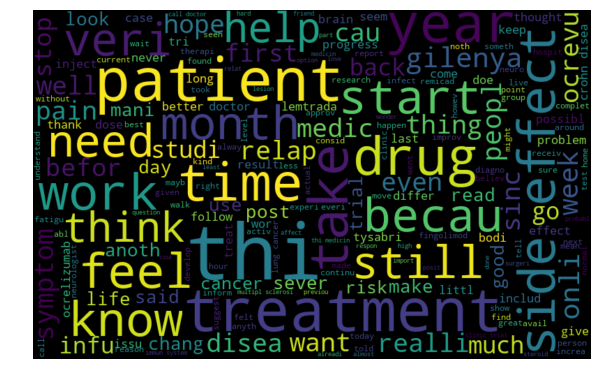

In [81]:
all_words = ' '.join([txt for txt in train['tidy_text'][train['sentiment']==1]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Word Cloud for sentiment class 1**




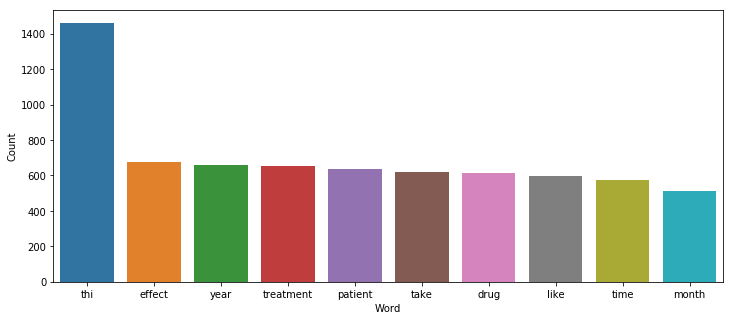

In [86]:
all_words = ' '.join([txt for txt in train['tidy_text'][train['sentiment']==1]])
all_words = all_words.split()

stop_words = set(stopwords.words('english'))
words = [word for word in all_words if word not in stop_words]
a = nltk.FreqDist(words)
d = pd.DataFrame({'Word': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(12,5))
ax = sns.barplot(data=d, x= "Word", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

* Frequency distribution (Sentiment Class 1)*

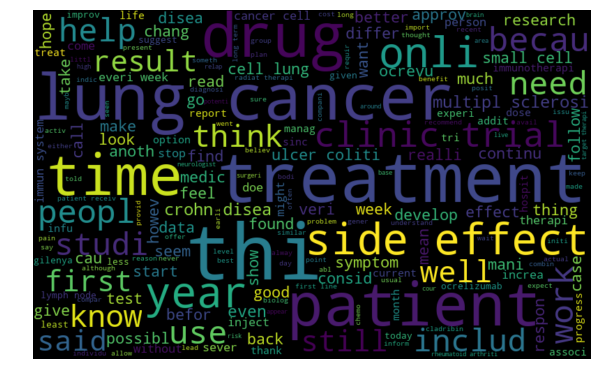

In [82]:
all_words = ' '.join([txt for txt in train['tidy_text'][train['sentiment']==2]])

wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

**Word Cloud for sentiment class 2**

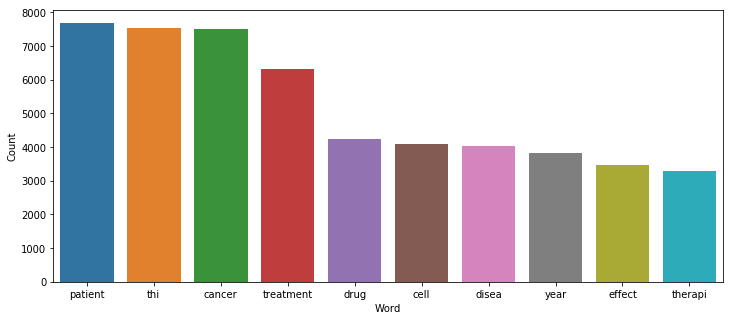

In [87]:
all_words = ' '.join([txt for txt in train['tidy_text'][train['sentiment']==2]])
all_words = all_words.split()

stop_words = set(stopwords.words('english'))
words = [word for word in all_words if word not in stop_words]
a = nltk.FreqDist(words)
d = pd.DataFrame({'Word': list(a.keys()),
                  'Count': list(a.values())})
# selecting top 10 most frequent hashtags     
d = d.nlargest(columns="Count", n = 10) 
plt.figure(figsize=(12,5))
ax = sns.barplot(data=d, x= "Word", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

* Frequency distribution (Sentiment Class 2)*

# Features and  Models

The problem description evaluates our solutions based on f1 scores. So let us write a custom function wrapper that uses f1 score for evaluation.

In [0]:
from sklearn.metrics import f1_score

def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

**Bag of words approach**

In [0]:
combi = train.append(test, ignore_index=True)

**Bag of words features**

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combi['tidy_text'])

In [95]:
bow

<8203x1000 sparse matrix of type '<class 'numpy.int64'>'
	with 482730 stored elements in Compressed Sparse Row format>

**Tf-Idf Features**

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')

# TF-IDF feature matrix
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_text'])

In [182]:
tfidf

<8203x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 482730 stored elements in Compressed Sparse Row format>

# Building model using Bag of Words

In [183]:
from scipy.sparse import hstack

bow_data = hstack((bow, drugs))
print (bow_data.shape)

tfidf_data = hstack((tfidf, drugs))
print (tfidf_data.shape)

(8203, 1111)
(8203, 1111)


In [0]:
bow_data = bow_data.tocsr()
tfidf_data = tfidf_data.tocsr()

In [0]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score


train_bow = tfidf[:5279,:]
test_bow = tfidf[5279:,:]


# splitting data into training and validation set
xtrain_bow, xvalid_bow, ytrain, yvalid = train_test_split(train_bow, train['sentiment'], random_state=42, test_size=0.3)

In [0]:
xvalid_bow, xtest_bow, yvalid, ytest = train_test_split(xvalid_bow, yvalid, random_state=42, test_size=0.5)

# Xg-Boost

In [199]:
import xgboost as xgb

dtrain = xgb.DMatrix(xtrain_bow, label=ytrain)
dvalid = xgb.DMatrix(xvalid_bow, label=yvalid)
dtest = xgb.DMatrix(xtest_bow, label=ytest)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [0]:
param = {
    'max_depth': 5,  # the maximum depth of each tree
    'eta': 0.3,  # the training step for each iteration
    'verbosity': 2,  # logging mode - quiet
    'objective': 'multi:softprob', 
    'metric': 'mlogloss',# error evaluation for multiclass training
    'num_class': 3,
    'tree_method': 'auto'
    } 

In [218]:
bst = xgb.train(param, dtrain, num_boost_round=1000, early_stopping_rounds=5, evals=([dtrain, 'train'], [dvalid, 'validation']))

[10:58:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 0 pruned nodes, max_depth=5
[10:58:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[10:58:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[0]	train-merror:0.241949	validation-merror:0.286616
Multiple eval metrics have been passed: 'validation-merror' will be used for early stopping.

Will train until validation-merror hasn't improved in 5 rounds.
[10:58:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 38 extra nodes, 0 pruned nodes, max_depth=5
[10:58:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[10:58:44] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 42 extra nodes, 0 pruned nodes, max_depth=5
[1]	train-merro

In [219]:
bst.best_iteration

1

In [0]:
pred = bst.predict(dtest)
preds = pred.argmax(axis=1)

# Light GBM

In [0]:
params_gbm = {
          "objective" : "multiclass",
          "num_class" : 4,
          "num_leaves" : 60,
          "max_depth": -1,
          "learning_rate" : 0.01,
          "bagging_fraction" : 0.9,  # subsample
          "feature_fraction" : 0.9,  # colsample_bytree
          "bagging_freq" : 5,        # subsample_freq
          "bagging_seed" : 2018,
          "verbosity" : 1 }

In [0]:
lgtrain, lgval = lgb.Dataset(xtrain_bow, ytrain), lgb.Dataset(xvalid_bow, yvalid)
lgbmodel = lgb.train(params, lgtrain, 2000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, verbose_eval=200)

In [221]:
from sklearn.metrics import accuracy_score
print (accuracy_score(preds, ytest))

0.726010101010101




1.   for max_features = 1000 (bow vectorizer), accuracy on test set was = 0.7108585858585859
2.   for max_features = 2000 (bow vectorizer), accuracy on test set was = 0.7159090909090909
3.   for max_features = 2000 (bow vectorizer), early_stopping_rounds = 2 accuracy on test set was = 0.726010101010101
4.   for max_features = 2000 (bow vectorizer), early_stopping_rounds = 100 accuracy on test set was = 0.7171717171717171
5.   for max_features = 1000 (tfidf vectorizer), early_stopping = 10, accuracy on test = 0.7335858585858586 (drugs not added)
6.   for max_features = 1111 (bow vectorizer), early_stopping = 10, accuracy on test = 0.7310606060606061 (drugs  added)



In [0]:
tmp = xgb.DMatrix(test_bow)
preds = bst.predict(tmp)
final = preds.argmax(axis=1)
test = pd.read_csv('drive/My Drive/Data Science Preparation/Innoplexus Sentiment Analysis/sample_submission_i5xnIZD.csv')
test.head()
test['sentiment'] = final
test.to_csv('submission_3.csv', index=False)

In [213]:
test.sentiment.value_counts()

2    2894
1      28
0       2
Name: sentiment, dtype: int64

# Whole data bunched and model trained 
*Not final only experimental purposes*

In [212]:
from scipy.sparse import vstack

def use_all(name):
  data = vstack([xtrain_bow, xvalid_bow, xtest_bow])
  print (data.shape)
  target = pd.concat([ytrain, yvalid, ytest])
  dtrain = xgb.DMatrix(data, label=target)
  full_model = xgb.train(param, dtrain, num_boost_round=13)
  tmp = xgb.DMatrix(test_bow)
  preds = bst.predict(tmp)
  final = preds.argmax(axis=1)
  test = pd.read_csv('drive/My Drive/Data Science Preparation/Innoplexus Sentiment Analysis/sample_submission_i5xnIZD.csv')
  test.head()
  test['sentiment'] = final
  test.to_csv(name, index=False)
  

use_all('full_data_3.csv')

(5279, 1000)
[10:05:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[10:05:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:05:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:05:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[10:05:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:05:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[10:05:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:05:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:05:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:05:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nodes, 0 pruned nodes, max_depth=3
[10:05:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:05:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:05:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[10:05:54] INFO: /workspace/src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 12 extra nod